In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv1D, UpSampling1D, Dropout, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

import numpy as np

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from time import time
import os

from scipy.signal import spectrogram, istft

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

import seaborn as sns


Using TensorFlow backend.


## Load data and preprocess

In [5]:
waveform_filename = 'hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed'

if os.path.exists(waveform_filename):
    print('{} exists, loading'.format(waveform_filename))
    stream = obspy.read(waveform_filename)
    
else:
    print("{} doesn't exist, processing file".format(waveform_filename))
    stream = obspy.read('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms.mseed')

    client = Client('IRIS')

    starttime = UTCDateTime('2018-04-01')
    endtime = UTCDateTime('2018-8-31')
    POHA = client.get_stations(network="IU", station="POHA", 
                               starttime=starttime, endtime=endtime,
                              level='response')

    print("Removing seismometer response...")
    stream.remove_response(POHA)
    print("Filtering waveforms...")
    stream.filter('bandpass', freqmin=3, freqmax=8, corners=2, zerophase=True)
    print("Normalizing waveforms...")
    stream.normalize()
    print("Done")

    stream.write('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed')
    
cat = obspy.core.event.read_events('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml')    

hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed doesn't exist, processing file
Removing seismometer response...
Filtering waveforms...
Normalizing waveforms...
Done


## Create Spectrograms

41476


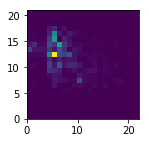

In [4]:
df = 20
trace_length = 40

spectrograms = []

for tr in stream:
    if len(tr.data) == trace_length*df:
        _, _, Sxx = spectrogram(tr.data, nperseg=int(df*2), scaling='spectrum')
        spectrograms.append(Sxx.T)
f = plt.figure(figsize=(2,2))    
plt.pcolormesh(spectrograms[10].T)
print(len(spectrograms))

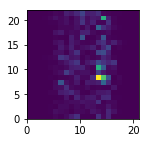

In [5]:
f = plt.figure(figsize=(2,2))
plt.pcolormesh(spectrograms[40000])

In [6]:
np.array(spectrograms).shape


(41476, 22, 21)

In [11]:
X = np.array(spectrograms)

X_train, X_val = test_train_split(X)

# Create a 1D causal convolutional autoencoder for seismic spectrogram feature extraction

based on https://blog.keras.io/building-autoencoders-in-keras.html, https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

In [7]:
# Maybe I should class this

def build_model(latent_dims, input_shape, n_filters=32, dilation_rate=2, n_layers=4):
    
    # ENCODER
    encoder_input = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    x = encoder_input
    
    for i in [dilation_rate**i for i in range(n_layers)]:
        x = Conv1D(n_filters, 2, dilation_rate=i, activation='relu', padding='causal')(x)

    encode = Flatten()(x)
    encode = Dense(latent_dims)(encode)
    encode = Reshape((1,latent_dims))(encode)

    # DECODER
    #decoder_input = Input(shape=(1,latent_dims))
    decode = Dense(input_shape[0], activation='relu')(encode)
    decode = Reshape((input_shape[0],1))(decode)
    #x = decoder
    
    skips = []
    for i in [dilation_rate**i for i in range(n_layers)][::-1][:-1]:
        #last step should be a dilatation of 1, skip this to put a sigmoid activation on last layer
        lyr = Conv1D(n_filters, 2, dilation_rate=i,activation='relu', padding='causal')(decode)
        skips.append(lyr)
        decode = lyr
        #x = UpSampling1D(2)(x)      

    decode = Conv1D(n_filters, 2, dilation_rate=1, activation='sigmoid', padding='causal')(decode)
    decode = Dense(input_shape[1])(decode)

    encoder = Model(encoder_input, encode)
    #decoder = Model(decoder_input, decode)
    autoencoder = Model(encoder_input, decode)
    
    #decoder = Model(latent, decoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    #encoder.compile()
    
    return autoencoder, encoder #, decoder



In [8]:
n_filters = 64
latent_dims = 10
n_layers = 4
model_time = time()

input_shape = (spectrograms[0].shape[0], spectrograms[0].shape[1])
autoencoder, encoder = build_model(latent_dims, 
                                   (input_shape), 
                                   n_filters=n_filters, 
                                   n_layers=n_layers)

autoencoder.summary()

# create encoder model
inp = Input(shape=(10,))
m=inp
for layer in autoencoder.layers[8:]:
    m = layer(m)
    
decoder = Model(inp,m)

decoder.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            2752      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dens

## Setup the model and run
TODO: 
    - test multiple hyperparameters such as 
        - filters per layer
        - presence/absence of residual connections (not implemented)
        - presence/absence of full wavenet architecture (not implemented)

In [ ]:
checkpoint = ModelCheckpoint('convolutional_spectrogram/weights/weights_{}layers_{}filters_{}latent_{}.hdf5'.format(n_layers, n_filters, latent_dims,model_time), 
                                monitor='loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='convolutional_spectrogram/logs/log_{}layers_{}filters_{}latent_{}'.format(n_layers,n_filters, latent_dims, model_time))
#lrscheduler = LearningRateSchedular
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             patience=50, 
                             factor=0.3, 
                             min_delta=1e-7,
                            min_lr=1e-5)
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=1e-7, 
                          patience=100, 
                          verbose=1, 
                          mode='auto', 
                          restore_best_weights=True)
callbacks = [checkpoint, tensorboard, reduceLR, earlystop]

autoencoder.fit(X_train, X_train, 
                validation_data=(X_val,X_val),
                batch_size=512, 
                epochs=5000,  
                shuffle=True,
                callbacks=callbacks,
                verbose=1)

In [9]:
autoencoder.load_weights('convolutional_spectrogram/weights/weights_4layers_64filters_10latent_1563640004.316808.hdf5')

### Example original and reconstructed spectrogram from training data set

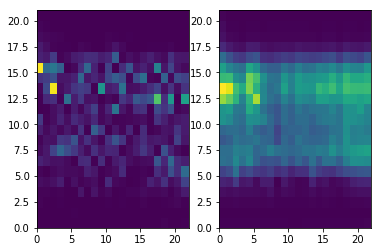

In [12]:
f, (ax1, ax2) = plt.subplots(1,2)
j = 1
ax1.pcolormesh(X_train[j].T)
predict = autoencoder.predict(X[j].reshape(1,X[j].shape[0],X[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X[j].shape[1],X[j].shape[0]))

### Example original and reconstructed spectrogram from validation data set

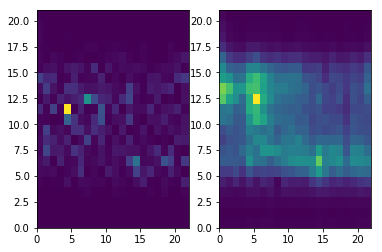

In [13]:
f, (ax1, ax2) = plt.subplots(1,2)
j = 1
ax1.pcolormesh(X_test[j].T)
predict = autoencoder.predict(X[j].reshape(1,X[j].shape[0],X[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X[j].shape[1],X[j].shape[0]))

### Calculate latent vectors from the dataset

In [14]:
encoder.compile(optimizer='adam', loss='mse')

In [15]:
latent_vectors = encoder.predict(X)
lvshape = latent_vectors.shape
latent_vectors = latent_vectors.reshape(lvshape[0],lvshape[2])

## K-means clustering

### Choose optimal number of clusters

In [16]:
scores = []
inertia = []

ks = range(2,12)

for num_clusters in ks:
    km = KMeans(num_clusters)
    cls = km.fit_predict(latent_vectors) 
    score = silhouette_score(latent_vectors, cls)
    #print("Silhouette score: {}".format(score))
    scores.append(score)
    #print("Inertia: {}".format(km.inertia_))
    inertia.append(km.inertia_)
    print("{} clusters fit".format(num_clusters))

2 clusters fit
Silhouette score: 0.28907760977745056
Inertia: 69981.04838007958
3 clusters fit
Silhouette score: 0.2707756459712982
Inertia: 57668.930045239445
4 clusters fit
Silhouette score: 0.2509140372276306
Inertia: 52605.481399026765
5 clusters fit
Silhouette score: 0.2629179358482361
Inertia: 48532.15242883962
6 clusters fit
Silhouette score: 0.2576102316379547
Inertia: 45711.78248144526
7 clusters fit
Silhouette score: 0.25019675493240356
Inertia: 43706.24156006552
8 clusters fit
Silhouette score: 0.24911458790302277
Inertia: 41943.54260618645
9 clusters fit
Silhouette score: 0.2528209090232849
Inertia: 40481.11766870573
10 clusters fit
Silhouette score: 0.25518402457237244
Inertia: 39107.167385487046
11 clusters fit
Silhouette score: 0.25495025515556335
Inertia: 38094.094946159275


Text(0, 0.5, 'Inertia')

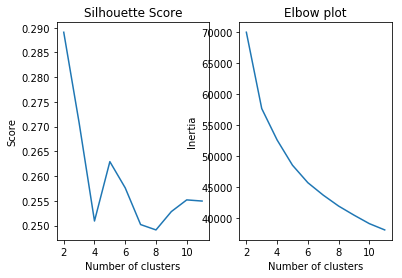

In [17]:
f, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(ks,scores)
ax1.set_title('Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Score')

ax2.plot(ks, inertia)
ax2.set_title('Elbow plot')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Inertia')

### 5 clusters chosen

In [18]:
n_clusters = 5

kmeans = KMeans(n_clusters)

clusters = kmeans.fit_predict(latent_vectors)

### 2D PCA 

Text(0.5, 1.0, 'PCA dimensionality reduction of clustered earthquakes')

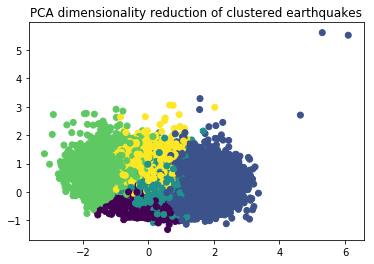

In [19]:
pca = PCA(n_components=2).fit_transform(latent_vectors)
f = plt.figure()
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.title('PCA dimensionality reduction of clustered earthquakes')

### 3D PCA

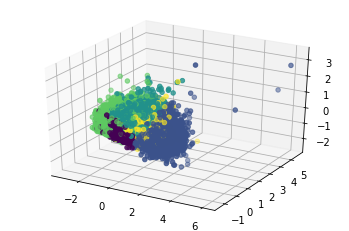

In [20]:
dpca = PCA(n_components=3).fit_transform(latent_vectors)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dpca[:,0], dpca[:,1], dpca[:,2], c=clusters)


### T-sne

In [21]:
ts = TSNE(perplexity=40).fit_transform(latent_vectors[:5000])



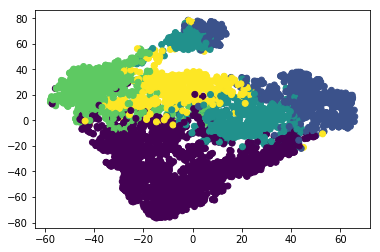

In [22]:
f = plt.figure()
plt.scatter(ts[:,0],ts[:,1], c=clusters[:5000])

## Plot some spectrograms for each cluster

The following are plots of the original event spectrogram and waveform, along with their reconstructions from the model.  Note how the reconstructions capture a qualitatively smoothed representation of the original spectrograms.


In [23]:
# group spectrograms by cluster, also add event info

predicted = autoencoder.predict(X)

import pandas as pd

clustered = pd.DataFrame({'cluster':clusters, 
                          'spectrogram':[x for x in X[:]], 
                          'predicted':[x for x in predicted[:]],
                          'mag':[x.magnitudes[0].mag for x in cat],
                          'time':[x.origins[0].time for x in cat],
                          'depth':[x.origins[0].depth for x in cat],
                          'lat':[x.origins[0].latitude for x in cat],
                          'long':[x.origins[0].longitude for x in cat]})

clustered.to_hdf5('convolutional_spectrogram_clusters.hdf5')

In [ ]:
clustered = pd.read_hdf5('convolutional_spectrogram_clusters.hdf5')

### Cluster 0

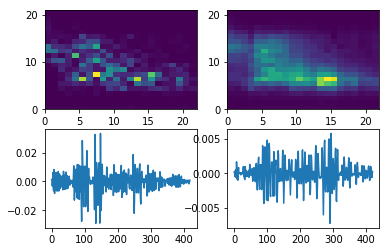

In [24]:
j = 10

spect = clustered[clustered.cluster==0].iloc[j].spectrogram
pred = clustered[clustered.cluster==0].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])



### Cluster 1

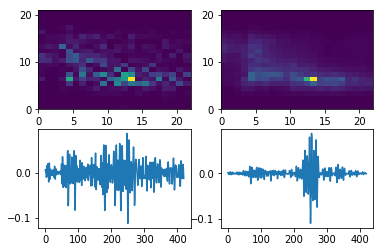

In [25]:
j = 20

spect = clustered[clustered.cluster==1].iloc[j].spectrogram
pred = clustered[clustered.cluster==1].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


### Cluster 2

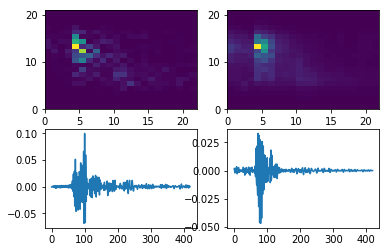

In [26]:
j = 100

spect = clustered[clustered.cluster==2].iloc[j].spectrogram
pred = clustered[clustered.cluster==2].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
j = 20000
ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


### Cluster 3

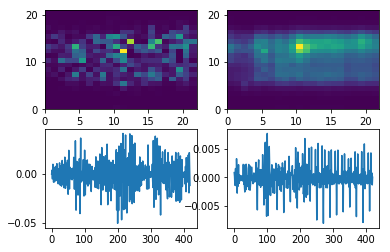

In [27]:
j = 2000

spect = clustered[clustered.cluster==3].iloc[j].spectrogram
pred = clustered[clustered.cluster==3].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
j = 20000
ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


### Cluster 4

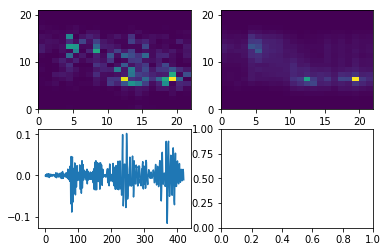

In [29]:
j = 2000

spect = clustered[clustered.cluster==4].iloc[j].spectrogram
pred = clustered[clustered.cluster==4].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
j = 20000
ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])

## Reconstructed spectrograms of the cluster centers
The following reconstruct the centroid vector for each cluster into it's spectrogram and waveform to visualize, in a sense, the average or prototypical spectrogram and waveform for each cluster.

In [30]:
centroid_spectrograms = decoder.predict(kmeans.cluster_centers_)

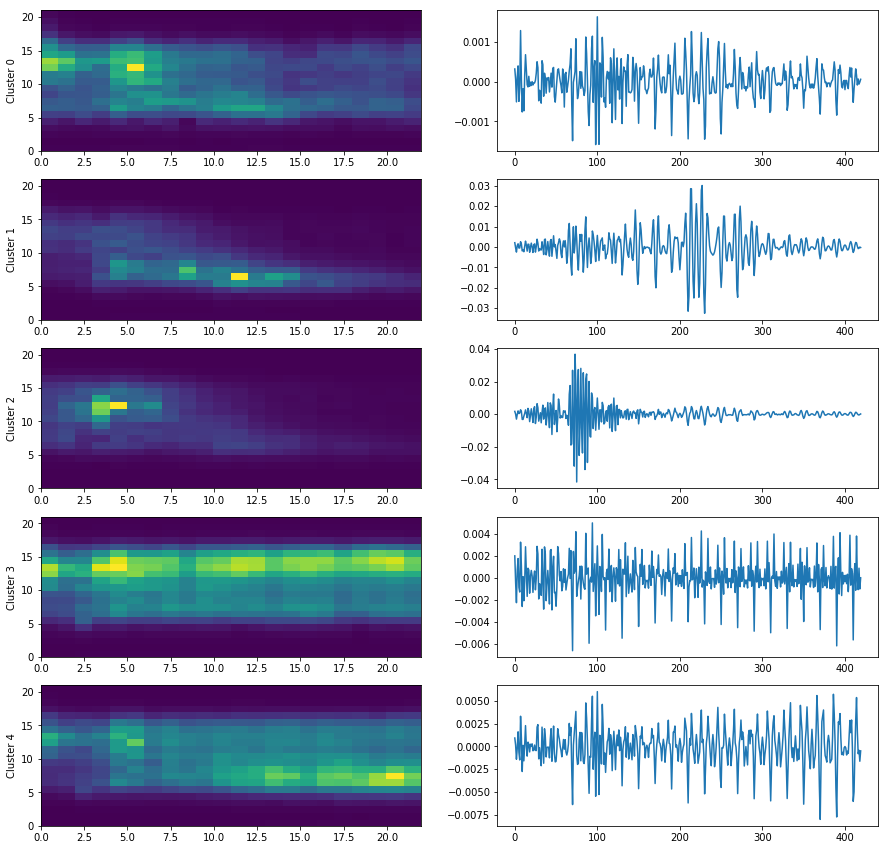

In [31]:
f, axes = plt.subplots(n_clusters,2, figsize=(15,15))

#f.set_title('Spectrograms and Waveforms for cluster centroid vectors')

for i, spect in enumerate(centroid_spectrograms):
    axes[i,0].pcolormesh(spect.T)
    axes[i,0].set_ylabel('Cluster {}'.format(i))
    axes[i,1].plot(istft(spect.T)[1])
    #axes[i,1].set_title('Cluster {} canonical centroid waveform’.format(i))



### Look at the latent vector centroids

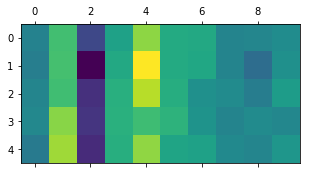

In [32]:
f,ax=plt.subplots(1,figsize=(5,5))
ax.matshow(kmeans.cluster_centers_)

In [33]:
pc = PCA(5)
pc.fit(kmeans.cluster_centers_)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<Figure size 432x288 with 0 Axes>

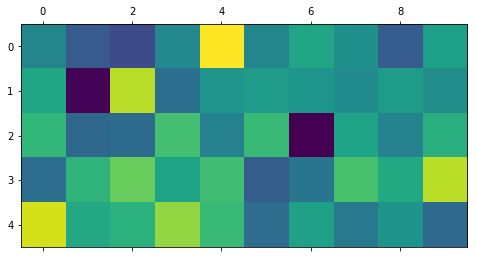

In [34]:
f=plt.figure()
plt.matshow(pc.components_)

## Look at magnitudes of each cluster, plot clusters in space and time

In [35]:
clustered.describe()

,cluster,mag,depth,lat,long
count,41476.000000,41476.000000,41476.000000,41476.000000,41476.000000
mean,1.542024,2.386331,1348.140515,19.404978,-155.265765
std,1.446375,0.433692,3512.512867,0.042116,0.073900
min,0.000000,1.500000,-3660.000000,18.801333,-156.450333
25%,0.000000,2.050000,290.000000,19.398500,-155.281662
50%,1.000000,2.360000,740.000000,19.408833,-155.272827
75%,3.000000,2.660000,1310.000000,19.417667,-155.264328
max,4.000000,6.900000,51700.000000,20.464000,-154.668335


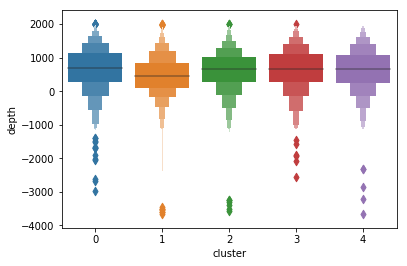

In [36]:
sns.boxenplot(x='cluster', y='depth', data=clustered[clustered.depth<2000])

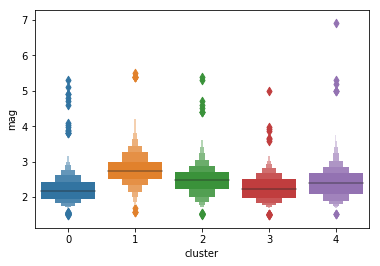

In [37]:
sns.boxenplot(x='cluster', y='mag', data=clustered)

In [1]:
plt.scatter(clustered['time'], clustered['cluster'])

NameError: name 'plt' is not defined